# Coursera Data Science Capstone
### Battle of the Neighborhoods - Final Project
**Author**: Bryan Baldwin <br>
**Date**: 11/10/2020

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data and Methodology](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>


In this final project, we will explore the optimal location for adding several food service stores in Chicago, IL, USA. These are stores designed to be food and equipment suppliers for area restaurants.

We want these four stores to be **in areas with dense clusters of restaurants** to maximize the potential local customer base. These stores should also be **evenly spread throughout the city** to maximize the footprint throughout the city. Lastly,  we will want to consider **proximity to existing food service stores** of competitors.

We will using data science methodology to find suitible locations to open food service stores.

In [1]:
import pandas as pd
import numpy as np

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


## Data and Methodology <a name="data"></a>

First we need to get regional data for Chicago, IL.Since our service area will include surrounding metro Chicago, we will get a list of neighborhoods. Chicago has Neighborhoods as a subset of the Community Area, but for this analysis, we will consider the Community Area as "Neighborhood" going forth. We will **pull a list of the neighborhoods data** from the "List of Neighborhoods in Chicago" wikipedia page to use as our research areas.

### Neighborhood List

In [2]:
# Read the table from the Wiki page into a DataFrame
chi_wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago')

In [3]:
chi_df = chi_wiki[0]
chi_df

,Neighborhood,Community area
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Archer Heights,Archer Heights
4,Armour Square,Armour Square
...,...,...
241,Wildwood,Forest Glen
242,Woodlawn,Woodlawn
243,Wrightwood,Ashburn
244,Wrightwood Neighbors,Lincoln Park


Now that we have our data, we will need to cleanse our data into a usable format. First, we will drop duplicate community areas to narrow down our search. Next, we will drop the "Neighborhood" column so we're only left with our Community Area. Finally, we will drop the astrisk from the County field.

**We will now refer to the community area as neighborhoods.**

In [4]:
chi_df = chi_df.drop_duplicates(subset=['Community area'],ignore_index=True)
chi_df = chi_df.drop(labels='Neighborhood', axis=1)
chi_df

,Community area
0,Albany Park
1,Riverdale
2,Edgewater
3,Archer Heights
4,Armour Square
...,...
77,West Englewood
78,West Garfield Park
79,"Austin, Humboldt Park"
80,West Pullman


Now that we have our Wikipedia table data cleaned up, let's extract a list of the counties so we can use the list to find coordinates of each.

In [5]:
# Creating a List of neighborhoods from the DataFrame data
neighborhoods = chi_df['Community area'].tolist()
neighborhoods

['Albany Park',
 'Riverdale',
 'Edgewater',
 'Archer Heights',
 'Armour Square',
 'Ashburn',
 'Auburn Gresham',
 'Avalon Park',
 'Avondale',
 'Irving Park',
 'New City',
 'Belmont Cragin',
 'Hermosa',
 'Dunning',
 'Beverly',
 'Morgan Park',
 'Norwood Park',
 'Lake View',
 'Lincoln Square',
 'Washington Heights',
 'Bridgeport',
 'Brighton Park',
 'Douglas',
 'Logan Square',
 'Uptown',
 'Burnside',
 'Near North Side',
 'Calumet Heights',
 'Near South Side',
 'Chatham',
 'Chicago Lawn',
 'Clearing',
 'Pullman',
 'North Lawndale',
 'East Garfield Park',
 'Hyde Park',
 'Lower West Side',
 'East Side',
 'West Town',
 'Forest Glen',
 'Edison Park',
 'Englewood',
 'Roseland',
 'West Lawn',
 'Fuller Park',
 'Near West Side',
 'Gage Park',
 'Austin',
 'Garfield Ridge',
 'Jefferson Park',
 'Grand Boulevard',
 'Greater Grand Crossing',
 'Hegewisch',
 'North Park',
 'Humboldt Park',
 'South Shore',
 'Kenwood',
 'Lincoln Park',
 'South Lawndale',
 'The Loop',
 'Rogers Park',
 'McKinley Park',
 'Mont

### Neighborhood Coordinates

Now that we have our list, let's create a dataframe and initate the dataframe column names.

In [6]:
# Define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# Label the columns in the dataframe
neighborhood_loc_data = pd.DataFrame(columns=column_names)

We will loop through each county in the list and populate our dataframe with county and coordinates data. Due to Nominatim's user agreement, we will need to pause for 1 sec during each loop.

In [7]:
from time import sleep

for neighborhood in neighborhoods:
    
    address = neighborhood + ', Chicago, IL'

    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)

    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        address = neighborhood + ', IL'
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        try:
            latitude = location.latitude
            longitude = location.longitude
        except:
            latitude = np.nan
            longitude = np.nan
            
    if not 41 < latitude < 43:
            latitude = np.nan
            
    if not -88 < longitude < -86:
            longitude = np.nan
    
    neighborhood_loc_data = neighborhood_loc_data.append({'Neighborhood': neighborhood,
                                          'Latitude': latitude,
                                          'Longitude': longitude}, ignore_index=True)
     
    
    sleep(1)

In [8]:
neighborhood_loc_data.shape

(82, 3)

In [9]:
# Dropping two records that have returned errors when fetching coordinates data.
neighborhood_loc_data.dropna(inplace=True)
neighborhood_loc_data

,Neighborhood,Latitude,Longitude
0,Albany Park,41.971937,-87.716174
1,Riverdale,41.667835,-87.604964
2,Edgewater,41.983369,-87.663952
3,Archer Heights,41.811422,-87.726165
4,Armour Square,41.840033,-87.633107
...,...,...,...
77,West Englewood,41.778089,-87.666718
78,West Garfield Park,41.880588,-87.729223
79,"Austin, Humboldt Park",41.895125,-87.741004
80,West Pullman,41.671775,-87.638358


In [10]:
# We will find the avg for Lat and Lon in order to center our map
latitude = neighborhood_loc_data['Latitude'].mean(axis=0)
longitude = neighborhood_loc_data['Longitude'].mean(axis=0)
print('Center of of the Map:')
print('Latitude =',latitude)
print('Longitude =', longitude)

Center of of the Map:
Latitude = 41.845603266874996
Longitude = -87.67745961072562


### Map of Neighborhoods

Let's explore a map of Chicago with all the neighborhoods in our list.

In [11]:
# create map of Chicago using latitude and longitude values
map_chi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhood_loc_data['Latitude'], neighborhood_loc_data['Longitude'], neighborhood_loc_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chi)  
    
map_chi

### Foursquare Data - Surrounding Restaurants

Since the food service store services all types of food, supply, and equipment, we will use the Foursquare API to return all the restaurants within a 500 meter radius using the "Root" category for all food-related venues. We will then use this data to get a count of the number of possible clients in particular neighborhood as well as the distance from each venue to each neighborhood.

In [12]:
CLIENT_ID = 'BXUCPOEUBAZMUJNQU4Q1D1CD2K5BL4BLFSDMLDUQRMW0EVFM' # your Foursquare ID
CLIENT_SECRET = '4JGHXK0PMSZBUWDZIYC0NKJA1GA3W2MSYDO2QJG1LSY3KILY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

We'll use the Foursquare category ID for any food related venue (4d4b7105d754a06374d81259). (https://developer.foursquare.com/docs/build-with-foursquare/categories/)

In [13]:
food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

We will build a function that will build the call to Foursquare, send the request, received the response, and extract elements of the response into a dataframe.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            food_category,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
print('Complete!')

Complete!


In [20]:
chi_venues = getNearbyVenues(names=neighborhood_loc_data['Neighborhood'], latitudes=neighborhood_loc_data['Latitude'], longitudes=neighborhood_loc_data['Longitude'])

In [22]:
chi_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Albany Park,41.971937,-87.716174,Tre Kronor,41.975842,-87.711037,Scandinavian Restaurant
1,Albany Park,41.971937,-87.716174,Merla's Kitchen,41.976063,-87.713559,Restaurant
2,Albany Park,41.971937,-87.716174,2 Asian Brothers,41.975832,-87.709655,Vietnamese Restaurant
3,Albany Park,41.971937,-87.716174,Great Sea Chinese Restaurant,41.968496,-87.710678,Chinese Restaurant
4,Albany Park,41.971937,-87.716174,Peking Mandarin Resturant,41.968292,-87.715783,Chinese Restaurant
...,...,...,...,...,...,...,...
3129,Woodlawn,41.779479,-87.599493,Classics Cafe,41.787770,-87.601090,Café
3130,Woodlawn,41.779479,-87.599493,Common Knowledge Café,41.787993,-87.599637,Café
3131,Woodlawn,41.779479,-87.599493,Tres Original Pancakes,41.780869,-87.588188,Food
3132,Woodlawn,41.779479,-87.599493,Jazzman's Café & Bakery,41.788009,-87.602977,Café


### Distance of Venues to each Neighborhood

We are interested in the distance from each venues to each neighborhood. Proximity to venues is an important consideration in our search for the ideal neighborhoods.

In [23]:
# Create a DataFrame for our distances
chi_venues_dist = pd.DataFrame()

# Add the first column as the name of the Venues
chi_venues_dist['Venue'] = chi_venues['Venue']

In [24]:
# Uses geopy library and distance method to calculate distance in miles
import geopy.distance

# Loop through each neighborhood and get the distance to each venue and add it to the DataFrame
for lat, lng, neighborhood in zip(neighborhood_loc_data['Latitude'], neighborhood_loc_data['Longitude'], neighborhood_loc_data['Neighborhood']):
    coords_1 = (lat, lng)
    for i, row in chi_venues.iterrows():
        coords_2 = (row['Venue Latitude'], row['Venue Longitude'])

        chi_venues_dist.loc[i,neighborhood] = geopy.distance.distance(coords_1, coords_2).miles

In [25]:
# The resulting DataFrame
chi_venues_dist

,Venue,Albany Park,Riverdale,Edgewater,Archer Heights,Armour Square,Ashburn,Auburn Gresham,Avalon Park,Avondale,...,Lakeview,South Chicago,South Deering,Washington Park,West Elsdon,West Englewood,West Garfield Park,"Austin, Humboldt Park",West Pullman,Woodlawn
0,Tre Kronor,0.377666,21.951274,2.479816,11.374494,10.197844,15.756969,16.292087,17.135101,2.548200,...,3.669375,18.578177,20.852613,13.528713,12.574644,13.838279,6.640614,5.780891,21.318093,14.722950
1,Merla's Kitchen,0.315036,21.998895,2.603958,11.381574,10.263748,15.772738,16.330284,17.197643,2.566434,...,3.783020,18.649921,20.912180,13.589585,12.583404,13.875415,6.638688,5.762350,21.356423,14.788292
2,2 Asian Brothers,0.430122,21.932925,2.410400,11.378930,10.169354,15.756484,16.279151,17.108320,2.548706,...,3.612272,18.546042,20.827478,13.502986,12.578106,13.826012,6.650375,5.799677,21.304984,14.694610
3,Great Sea Chinese Restaurant,0.369475,21.456059,2.616198,10.870124,9.726390,15.250020,15.789821,16.657972,2.041378,...,3.373430,18.117000,20.371104,13.049168,12.069564,13.335397,6.142001,5.299536,20.815932,14.250332
4,Peking Mandarin Resturant,0.252353,21.511012,2.864980,10.839870,9.824834,15.237759,15.825134,16.746319,2.041011,...,3.596563,18.225590,20.452245,13.134767,12.042785,13.368840,6.092575,5.214338,20.850970,14.345523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3129,Classics Cafe,14.028204,8.279691,13.883361,6.662248,3.967744,6.329001,4.176636,3.018507,11.877499,...,11.118038,4.481635,6.765924,0.938339,6.388074,3.455276,9.207289,10.345824,8.233905,0.578142
3130,Common Knowledge Café,14.046151,8.297233,13.886096,6.731276,3.985694,6.403216,4.239179,3.018549,11.900031,...,11.121804,4.451724,6.764501,1.004039,6.461930,3.531864,9.250641,10.387312,8.266733,0.587670
3131,Tres Original Pancakes,14.746952,7.849036,14.511819,7.431264,4.696003,6.757853,4.357111,2.473194,12.619293,...,11.755279,3.719073,6.175979,1.742437,7.098075,4.061245,10.018000,11.152871,7.963284,0.591810
3132,Jazzman's Café & Bakery,13.972308,8.294395,13.844895,6.563716,3.913010,6.248876,4.123270,3.056746,11.816714,...,11.078484,4.551637,6.804506,0.841477,6.289721,3.363000,9.126014,10.266195,8.227701,0.615609


#### Average Distance to Restaurants within a Neighborhood from Neighborhood center

We will look at the average distance to all venues from a particular neighborhood. 

In [26]:
# We need to transpose our dataframe so it's indexed by our Neighborhoods
chi_venues_dist = chi_venues_dist.set_index('Venue').T
chi_venues_dist['Mean_Dist'] = chi_venues_dist.mean(axis=1)
chi_venues_dist

Venue,Tre Kronor,Merla's Kitchen,2 Asian Brothers,Great Sea Chinese Restaurant,Peking Mandarin Resturant,Noon O Kabab,Banpojung,Hot Dog Station,L.D. Pho,Lawrence Fish Market,...,Get It 'N GO,Lucy's Food Truck,Chef Alfredo's,Leon's Barbecue,Classics Cafe,Common Knowledge Café,Tres Original Pancakes,Jazzman's Café & Bakery,Café Logan,Mean_Dist
Albany Park,0.377666,0.315036,0.430122,0.369475,0.252353,0.541995,0.261826,0.314204,0.507920,0.577091,...,14.372344,15.002145,14.840075,14.741786,14.028204,14.046151,14.746952,13.972308,14.102893,7.473437
Riverdale,21.951274,21.998895,21.932925,21.456059,21.511012,21.305555,22.002332,21.451262,21.348850,21.660202,...,7.755355,7.424532,7.276771,7.846550,8.279691,8.297233,7.849036,8.294395,8.138153,15.918063
Edgewater,2.479816,2.603958,2.410400,2.616198,2.864980,2.558831,2.712269,2.762075,2.547725,3.373188,...,14.321915,14.837212,14.803926,14.509141,13.883361,13.886096,14.511819,13.844895,13.990710,7.880577
Archer Heights,11.374494,11.381574,11.378930,10.870124,10.839870,10.756168,11.351449,10.818272,10.797784,10.825799,...,6.497911,7.323758,6.736173,7.418535,6.662248,6.731276,7.431264,6.563716,6.577563,8.107871
Armour Square,10.197844,10.263748,10.169354,9.726390,9.824834,9.563861,10.284492,9.746536,9.606192,10.069986,...,4.336930,4.941623,4.813873,4.690189,3.967744,3.985694,4.696003,3.913010,4.046172,6.875522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Englewood,13.838279,13.875415,13.826012,13.335397,13.368840,13.193031,13.870014,13.318222,13.236362,13.480669,...,3.064099,3.816328,3.148329,4.047636,3.455276,3.531864,4.061245,3.363000,3.307758,9.033082
West Garfield Park,6.640614,6.638688,6.650375,6.142001,6.092575,6.039961,6.602206,6.079584,6.080269,6.054164,...,9.354428,10.126321,9.759146,10.008836,9.207289,9.250641,10.018000,9.126014,9.216660,6.513184
"Austin, Humboldt Park",5.780891,5.762350,5.799677,5.299536,5.214338,5.218964,5.713389,5.218909,5.256463,5.105830,...,10.508006,11.272905,10.917785,11.143992,10.345824,10.387312,11.152871,10.266195,10.360381,6.667646
West Pullman,21.318093,21.356423,21.304984,20.815932,20.850970,20.672492,21.351733,20.799876,20.715839,20.960452,...,7.650835,7.503209,7.200194,7.957919,8.233905,8.266733,7.963284,8.227701,8.069564,15.366168


### Number of Restaurants in Neighborhood

The number of venues within a neighborhood is an important consideration since these are the potential clients to a food service store.

In [27]:
chi_num_rest= chi_venues[['Venue','Neighborhood']].groupby('Neighborhood').count()
chi_num_rest.rename(columns={'Venue': 'Num_of_Restaurants'}, inplace=True)
chi_num_rest

,Num_of_Restaurants
Neighborhood,
Albany Park,57
Archer Heights,24
Armour Square,47
Ashburn,17
Auburn Gresham,17
...,...
West Pullman,6
West Ridge,61
West Town,100


Since there are two fewer columns, we can know that two neighborhoods have 0 venues, so we will want to add those neighborhoods back in with the value 0.

In [28]:
# First, we will extract all Neighbood names into a dataframe
neighborhood_names = neighborhood_loc_data[['Neighborhood']]
# Outer join the restaurant counts with the Neighorhood list
neighborhood_names = pd.merge(neighborhood_names,chi_num_rest,how='outer',on=['Neighborhood'])
# Fill the blank values with 0
neighborhood_names[['Num_of_Restaurants']] = neighborhood_names[['Num_of_Restaurants']].apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')
chi_num_rest = neighborhood_names
chi_num_rest

,Neighborhood,Num_of_Restaurants
0,Albany Park,57
1,Riverdale,0
2,Edgewater,100
3,Archer Heights,24
4,Armour Square,47
...,...,...
75,West Englewood,13
76,West Garfield Park,22
77,"Austin, Humboldt Park",11
78,West Pullman,6


### Restaurant Depot - Competitor info

Restaurant Depot is a competitor in the market, so we want to find their locations around the Chicago area. We will using web scraping methods to extract coordinates of all their locations and find out which stores are within 50 miles of Chicago.

In [29]:
# We will request the location webpage from Restaurant Depot's website.
from requests import get
url = 'https://www.restaurantdepot.com/locations/find-a-warehouse'
response = get(url)

In [30]:
# BeatifulSoup is an html parser that will help read html data into python
from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [31]:
# Extracting all latitude and longitude coordinates from the webpage
location_containers = html_soup.find_all('div', class_ = 'location')
print("The total number of Restaurant Depot locations is ", len(location_containers))

The total number of Restaurant Depot locations is  138


In [32]:
# Initialize and append lists of the location information for Restaurant Depot locations
RD_city = []
RD_lat = []
RD_lng = []

for i in range(len(location_containers)):
    city = location_containers[i].h3.text
    lat = location_containers[i]['data-lat']
    lng = location_containers[i]['data-lng']
    
    RD_city.append(city)
    RD_lat.append(lat)
    RD_lng.append(lng)

In [33]:
# Create and populate a DataFrame with location information
competitor_locs = pd.DataFrame({'City_State': RD_city, 'Lat': RD_lat, 'Lng':RD_lng})
competitor_locs

,City_State,Lat,Lng
0,"Birmingham, AL",33.4478213,-86.8242086
1,"Mesa, AZ",33.3799525,-111.8480504
2,"Phoenix, AZ",33.4922156,-112.1143083
3,"Tucson, AZ",32.2052187,-110.9780893
4,"Anaheim, CA",33.8564872,-117.8601145
...,...,...,...
133,"Virginia Beach, VA",36.8473168,-76.1565419
134,"Fife, WA",47.2456363,-122.3475309
135,"Seattle, WA",47.5688502,-122.3377981
136,"Woodinville, WA",47.7825523,-122.1497494


In [34]:
# Loop through each row to get the distance to the center of Chicago
for i, row in competitor_locs.iterrows():
    coords_1 = (latitude, longitude)
    coords_2 = (row['Lat'], row['Lng'])
    
    competitor_locs.loc[i,'Dist'] = geopy.distance.distance(coords_1, coords_2).miles

In [35]:
# We only want stores that within 50 miles the center of our neighborhoods
competitor_locs = competitor_locs[competitor_locs.Dist < 50].reset_index(drop=True)
competitor_locs.Lat = competitor_locs.Lat.astype(float)
competitor_locs.Lng = competitor_locs.Lng.astype(float)
competitor_locs

,City_State,Lat,Lng,Dist
0,"Alsip, IL",41.662919,-87.718281,12.783159
1,"Goose Island, IL",41.904716,-87.654286,4.251253
2,"Sauganash (Pulaski Rd), IL",41.878114,-87.629798,3.328789
3,"Des Plaines, IL",42.013750,-87.888293,15.897838
4,"Lombard, IL",41.906301,-88.034780,18.900988


Now we will loop through each neighborhood to find the distance to the 5 Restaurant Depot stores.

In [36]:
competitor_dist = pd.DataFrame()

for lat, lng, neighborhood in zip(neighborhood_loc_data['Latitude'], neighborhood_loc_data['Longitude'], neighborhood_loc_data['Neighborhood']):
    coords_1 = (lat, lng)
    # competitor_dist.loc[i,'City_State'] = competitor_locs.loc[i,'City_State']
    for i, row in competitor_locs.iterrows():
        coords_2 = (row['Lat'], row['Lng'])

        competitor_dist.loc[i,neighborhood] = geopy.distance.distance(coords_1, coords_2).miles

In [37]:
competitor_dist

,Albany Park,Riverdale,Edgewater,Archer Heights,Armour Square,Ashburn,Auburn Gresham,Avalon Park,Avondale,Irving Park,...,Lakeview,South Chicago,South Deering,Washington Park,West Elsdon,West Englewood,West Garfield Park,"Austin, Humboldt Park",West Pullman,Woodlawn
0,21.327272,5.873921,22.293143,10.256909,12.991904,5.851145,6.418910,8.778325,19.051871,20.017056,...,19.674624,9.951786,7.849194,10.336374,9.046765,8.383594,15.033014,16.068639,4.180790,10.120950
1,5.629767,16.545715,5.451184,7.430502,4.595896,11.238378,11.134579,11.529490,3.764191,5.086048,...,2.705647,12.888726,15.271932,7.964295,8.461500,8.762786,4.207838,4.520038,16.097485,9.094178
2,7.858125,14.569001,7.474596,6.776261,2.633690,9.943122,9.396417,9.426943,5.933833,7.263715,...,4.710934,10.702338,13.174646,5.937108,7.592933,7.161487,5.130980,5.854070,14.247304,6.984787
3,9.319893,27.995713,11.738368,16.274167,17.796802,20.519280,22.173744,24.140969,10.482457,9.216273,...,12.988971,25.948589,27.554177,20.667841,17.363784,19.876470,12.314076,11.162741,26.896251,21.981492
4,17.031302,27.635832,19.833653,17.216766,21.218324,19.978236,22.553669,25.577838,16.831311,16.082492,...,19.793028,27.629359,28.109807,22.890118,17.790717,20.954886,15.856256,15.167040,26.100278,24.109005


In [38]:
# Name the columns
comp_loc_city = competitor_locs['City_State'].tolist()
# Transpose the dataframe so the neighborhood names are index
competitor_dist = competitor_dist.T
competitor_dist.columns = comp_loc_city
# Calculate the mean distance to each of the competitor locations
competitor_dist['Mean_Dist'] = competitor_dist.mean(axis=1)
competitor_dist

,"Alsip, IL","Goose Island, IL","Sauganash (Pulaski Rd), IL","Des Plaines, IL","Lombard, IL",Mean_Dist
Albany Park,21.327272,5.629767,7.858125,9.319893,17.031302,12.233272
Riverdale,5.873921,16.545715,14.569001,27.995713,27.635832,18.524037
Edgewater,22.293143,5.451184,7.474596,11.738368,19.833653,13.358189
Archer Heights,10.256909,7.430502,6.776261,16.274167,17.216766,11.590921
Armour Square,12.991904,4.595896,2.633690,17.796802,21.218324,11.847323
...,...,...,...,...,...,...
West Englewood,8.383594,8.762786,7.161487,19.876470,20.954886,13.027844
West Garfield Park,15.033014,4.207838,5.130980,12.314076,15.856256,10.508433
"Austin, Humboldt Park",16.068639,4.520038,5.854070,11.162741,15.167040,10.554506
West Pullman,4.180790,16.097485,14.247304,26.896251,26.100278,17.504422


So we are left with 3 compiled DataFrames: **chi_venues_dist**, **chi_num_rest**, and **competitor_dist**

## Analysis <a name="methodology"></a>

We will use number of restaurants, distance to restaurants, and proximity to competitors to use machine learning to cluster our data into groups. </b>
    
First, we want to cluster the distances from neighborhoods to restaurants.

### Neighborhood Distance Clusters

We will find the number optimimal number of "K" clusters by utilizing the "Elbow Method".

In [39]:
# Delete once complete
#neighborhood_loc_data =neighborhood_loc_data.drop('Cluster Labels', 1)
#neighborhood_loc_data

Text(0.5, 1.0, 'Elbow curve')

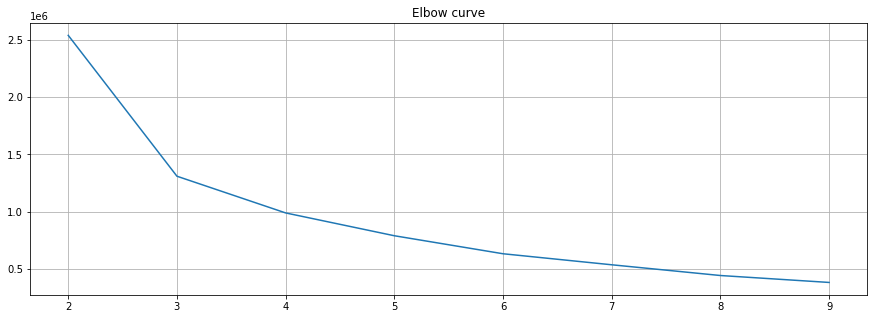

In [40]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

X = chi_venues_dist
distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [41]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chi_venues_dist)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 1, 0, 0, 2, 2, 2, 1, 1])

In [42]:
neighborhood_loc_data_Kmeans = neighborhood_loc_data
# Adding the clusters to the dataframe
neighborhood_loc_data_Kmeans.insert(0,'Cluster_Labels', kmeans.labels_)
neighborhood_loc_data_Kmeans

,Cluster_Labels,Neighborhood,Latitude,Longitude
0,1,Albany Park,41.971937,-87.716174
1,2,Riverdale,41.667835,-87.604964
2,1,Edgewater,41.983369,-87.663952
3,0,Archer Heights,41.811422,-87.726165
4,0,Armour Square,41.840033,-87.633107
...,...,...,...,...
77,0,West Englewood,41.778089,-87.666718
78,1,West Garfield Park,41.880588,-87.729223
79,1,"Austin, Humboldt Park",41.895125,-87.741004
80,2,West Pullman,41.671775,-87.638358


Now, let's visualize the resulting clusters

In [43]:
# create map
rest_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhood_loc_data_Kmeans['Latitude'], neighborhood_loc_data_Kmeans['Longitude'], neighborhood_loc_data_Kmeans['Neighborhood'], neighborhood_loc_data_Kmeans['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(rest_map_clusters)
       
rest_map_clusters

In [44]:
# Counts the number of neighborhoods in each cluster
neighborhood_loc_data_Kmeans.Cluster_Labels.value_counts()

1    33
0    28
2    19
Name: Cluster_Labels, dtype: int64

###  Mergered Data Clustering

Now that we have our 3 datasets, let's merge them together for a final k-means analysis on our 3 criterias.

In [45]:
# Our first dataframe will be the neighborhood clusters
df1 = neighborhood_loc_data_Kmeans.iloc[:, 0:2]
df1.reset_index(drop=True, inplace=True)
df1

,Cluster_Labels,Neighborhood
0,1,Albany Park
1,2,Riverdale
2,1,Edgewater
3,0,Archer Heights
4,0,Armour Square
...,...,...
75,0,West Englewood
76,1,West Garfield Park
77,1,"Austin, Humboldt Park"
78,2,West Pullman


In [46]:
from sklearn.preprocessing import normalize
# Our second dataframe will be the number of restaurants
df2 = chi_num_rest
df2[['Num_of_Restaurants']] = normalize(df2[['Num_of_Restaurants']], axis=0, norm='max')
df2

,Neighborhood,Num_of_Restaurants
0,Albany Park,0.57
1,Riverdale,0.00
2,Edgewater,1.00
3,Archer Heights,0.24
4,Armour Square,0.47
...,...,...
75,West Englewood,0.13
76,West Garfield Park,0.22
77,"Austin, Humboldt Park",0.11
78,West Pullman,0.06


In [47]:
# Our third dataframe will be the competitor distances
df3 = competitor_dist[['Mean_Dist']]
df3 = df3.reset_index()
df3 = df3.rename(columns = {'index':'Neighborhood'}, inplace = False)
df3[['Mean_Dist']] = normalize(df3[['Mean_Dist']], axis=0, norm='max')
df3

,Neighborhood,Mean_Dist
0,Albany Park,0.586679
1,Riverdale,0.888369
2,Edgewater,0.640627
3,Archer Heights,0.555873
4,Armour Square,0.568169
...,...,...
75,West Englewood,0.624784
76,West Garfield Park,0.503959
77,"Austin, Humboldt Park",0.506169
78,West Pullman,0.839470


In [48]:
# Compile a list of te dataframes we want to merge.
from functools import reduce

data_frames = [df2, df1, df3]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Neighborhood'], how='outer'), data_frames)
df_merged

,Neighborhood,Num_of_Restaurants,Cluster_Labels,Mean_Dist
0,Albany Park,0.57,1,0.586679
1,Riverdale,0.00,2,0.888369
2,Edgewater,1.00,1,0.640627
3,Archer Heights,0.24,0,0.555873
4,Armour Square,0.47,0,0.568169
...,...,...,...,...
75,West Englewood,0.13,0,0.624784
76,West Garfield Park,0.22,1,0.503959
77,"Austin, Humboldt Park",0.11,1,0.506169
78,West Pullman,0.06,2,0.839470


Now with our merged data, let's run a k means analysis.

Text(0.5, 1.0, 'Elbow curve')

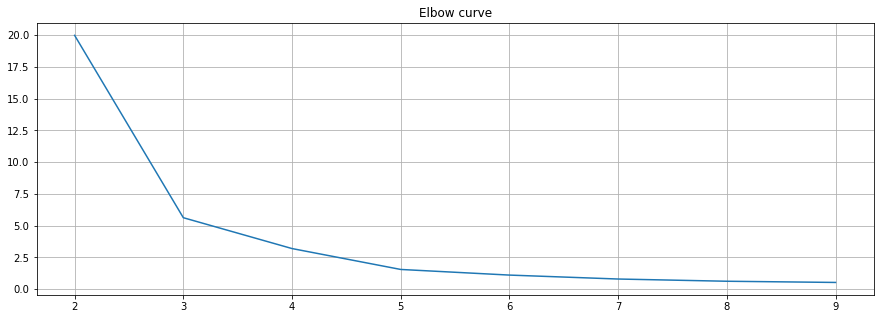

In [49]:
Y = df_merged.drop('Neighborhood', 1)

distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Y)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [50]:
# set number of clusters to 3 since that's where the sharp bend in the elbow is
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Y)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 2, 0, 0, 1, 1, 1, 2, 2])

In [51]:
merged_Kmeans = neighborhood_loc_data
merged_Kmeans.insert(0,'Loc_Clusters', kmeans.labels_)
merged_Kmeans

,Loc_Clusters,Cluster_Labels,Neighborhood,Latitude,Longitude
0,2,1,Albany Park,41.971937,-87.716174
1,1,2,Riverdale,41.667835,-87.604964
2,2,1,Edgewater,41.983369,-87.663952
3,0,0,Archer Heights,41.811422,-87.726165
4,0,0,Armour Square,41.840033,-87.633107
...,...,...,...,...,...
77,0,0,West Englewood,41.778089,-87.666718
78,2,1,West Garfield Park,41.880588,-87.729223
79,2,1,"Austin, Humboldt Park",41.895125,-87.741004
80,1,2,West Pullman,41.671775,-87.638358


Now, let's visualize the resulting clusters

In [52]:
# create map
loc_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhood_loc_data_Kmeans['Latitude'], neighborhood_loc_data_Kmeans['Longitude'], merged_Kmeans['Neighborhood'], merged_Kmeans['Loc_Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(loc_map_clusters)
       
loc_map_clusters

Now that we have our clusters, we want to find the center of the clusters as optimal locations for our food service stores.

In [53]:
ideal_locs = merged_Kmeans.groupby(['Loc_Clusters']).mean()
ideal_locs

,Cluster_Labels,Latitude,Longitude
Loc_Clusters,,,
0,0,41.816540,-87.664468
1,2,41.712639,-87.615488
2,1,41.946818,-87.724163


In [54]:
# create map
ideal_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map for the neighborhoods colored by cluster
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhood_loc_data_Kmeans['Latitude'], neighborhood_loc_data_Kmeans['Longitude'], merged_Kmeans['Neighborhood'], merged_Kmeans['Loc_Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.2).add_to(ideal_map_clusters)

# add markers to the map for the ideal locations for food service stores
markers_colors = []
for lat, lon, cluster in zip(ideal_locs['Latitude'], ideal_locs['Longitude'], merged_Kmeans['Loc_Clusters']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=12,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(ideal_map_clusters)
    
# add markers to the map for the locations of Restaurant Depot
markers_colors = []
for lat, lon, stores in zip(competitor_locs['Lat'], competitor_locs['Lng'], competitor_locs['City_State']):
    label = folium.Popup(' Restaurant Depot:  ' + str(stores), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=12,
        popup=label,
        color='white',
        fill=True,
        fill_color='white',
        fill_opacity=0.2).add_to(ideal_map_clusters)
       
ideal_map_clusters

Finally, we want to indentify the neighborhoods closest to the center of each cluster to name the ideal Neighborhood for our food service stores.

In [55]:
ideal_loc_dist = pd.DataFrame()
ideal_loc_dist['Neighborhood'] = merged_Kmeans['Neighborhood']

# Loop through each neighborhood and get the distance to each venue and add it to the DataFrame
for lat, lng, locat in zip(ideal_locs['Latitude'], ideal_locs['Longitude'], [0,1,2]):
    coords_1 = (lat, lng)
    for i, row in merged_Kmeans.iterrows():
        coords_2 = (row['Latitude'], row['Longitude'])

        ideal_loc_dist.loc[i,locat+1] = geopy.distance.distance(coords_1, coords_2).miles

In [56]:
ideal_loc_dist

,Neighborhood,1,2,3
0,Albany Park,11.051376,18.634799,1.781778
1,Riverdale,10.713811,3.139647,20.214016
2,Edgewater,11.513977,18.851326,3.997819
3,Archer Heights,3.204971,8.898578,9.345160
4,Armour Square,2.291207,8.839145,8.738612
...,...,...,...,...
77,West Englewood,2.656247,5.235920,12.016255
78,West Garfield Park,5.541194,12.994392,4.578452
79,"Austin, Humboldt Park",6.708977,14.164330,3.671772
80,West Pullman,10.081625,3.058222,19.492402


In [57]:
Ideal_1 = ideal_loc_dist.iloc[ideal_loc_dist[1].idxmin(axis=0)]['Neighborhood']
Ideal_2 = ideal_loc_dist.iloc[ideal_loc_dist[2].idxmin(axis=0)]['Neighborhood']
Ideal_3 = ideal_loc_dist.iloc[ideal_loc_dist[3].idxmin(axis=0)]['Neighborhood']

print(Ideal_1)
print(Ideal_2)
print(Ideal_3)

New City
Roseland
Portage Park


## Results and Discussion <a name="results"></a>

Although there are many other venues that our food service supplier services such as stadiums, hospitals, schools, and caterers, we decided to focus on resturants. Non-restaurant customers generally receive larger and more frequent deliveries from the warehouses as compared to restaurants. This means deliveries to restaurants are not as frequent and in smaller quantities. Restaurant customers are not as predicable as the other types of venues as well, thus there is more deviation in demand. 

Rather than holding more stock on hand, many of the restaurants rely on having food service stores that they can have an employee travel to in order to get a supply quickly to supplement their normal orders from the warehouse. Therefore, it is critical to have the best locations to provide access to as many restaurants as possible, in as convenient locations as possible.

Our analysis revealed that the neighborhoods of **New City**, **Roseland**, and **Portage Park** we the ideal candidate neighborhoods to build. As you can see from the map above, they are strategically located to take into account proximity factors to competitors and restaurants.



## Conclusion <a name="conclusion"></a>

Our purpose was to identify the ideal number of stores and locations to place food service supply stores in the Chicago area. The stakeholders want to ensure they don't have too many stores and be ineffiecent with their physical footprint. They also want to know that they are well suited for potential business.

The way we achieved these objectives is to cluster the neighborhoods in the Chicago area to build neighborhood zones. Using those zones of service, we factored in the number of restaurants in each neighborhood as well as five competitor locations. These all came together to build zones of service. Finally, we identified the neighborhoods at the center of these zones as our recommnedation to the stakeholder that these were the ideal locations for their restaurant supply stores.